In [ ]:
# Installazione dei pacchetti richiesti
!pip install rdkit-pypi
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric

# Importazione delle librerie
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import os
from copy import deepcopy
from sklearn.utils import shuffle
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [ ]:
# Caricamento dei dati dal file CSV
data = pd.read_csv('/content/D3_226k_docking_results.csv', sep=';')

In [ ]:
# Funzione per generare il Morgan Fingerprint
# smiles -> rappresenta la struttura chimica di una molecola utilizzando il codice ASCII
# radius -> considera i legami attorno a ciascun atomo per generare il fingerprint
# n_bits -> numero di bit della fingerprint
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)  # Converte la stringa SMILES in un oggetto molecolare
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return None  # Nel caso in cui lo SMILES sia invalido

# Applicazione della funzione a ogni elemento della colonna 'SMILES' creando una nuova colonna
data['fingerprint'] = data['SMILES'].apply(smiles_to_fingerprint)

# Eliminazione delle righe con fingerprint None
data = data[data['fingerprint'].notnull()]

In [ ]:
# Verifica e rimozione dei duplicati
print(f"Numero di righe iniziali: {len(data)}")

# Conversione delle fingerprint in formato hashabile per verificare i duplicati
data['fingerprint_str'] = data['fingerprint'].apply(lambda x: x.ToBitString())

# Identificazione dei duplicati
duplicati = data.duplicated(subset='fingerprint_str', keep=False)
if duplicati.any():
    print(f"Numero di duplicati trovati: {duplicati.sum()}")
    # Rimozione dei duplicati mantenendo solo la prima occorrenza
    data = data.drop_duplicates(subset='fingerprint_str', keep='first')
else:
    print("Nessun duplicato trovato.")

# Rimozione della colonna temporanea
data = data.drop(columns=['fingerprint_str'])

print(f"Numero di righe dopo la rimozione dei duplicati: {len(data)}")

Numero di righe iniziali: 226650
Numero di duplicati trovati: 44510
Numero di righe dopo la rimozione dei duplicati: 202061


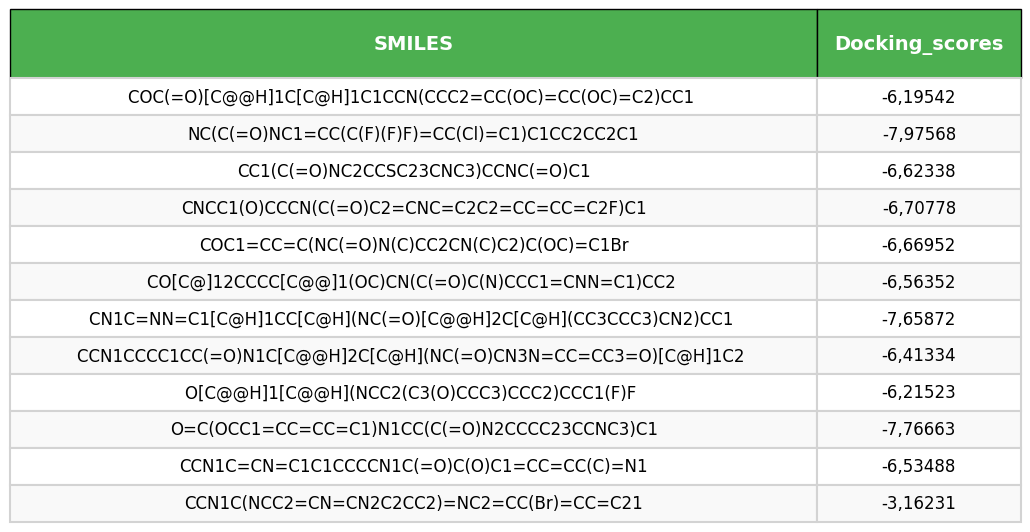

In [ ]:
# Selezione delle colonne da visualizzare
columns_to_display = ['SMILES', 'Docking_scores']
styled_data = data[columns_to_display].head(12)

# Creazione della tabella come immagine
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Stile della tabella
table = ax.table(cellText=styled_data.values,
                 colLabels=styled_data.columns,
                 cellLoc='center',
                 loc='center')

# Personalizzazioni grafiche
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(styled_data.columns))))

# Colore di sfondo delle intestazioni e altezza delle righe
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Righe delle intestazioni
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4CAF50')
        cell.set_fontsize(14)
        cell.set_height(0.15)
    else:
        cell.set_facecolor('#f9f9f9' if row % 2 == 0 else '#ffffff')
        cell.set_edgecolor('#d3d3d3')
        cell.set_linewidth(1.5)
        cell.set_height(0.08)

# Salvataggio della tabella come immagine
plt.savefig("table.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Estrazione dei fingerprint e dei docking score dal DataFrame
fingerprints = list(data['fingerprint'])

# Conversione dei docking score in float
docking_scores = data['Docking_scores'].str.replace(',', '.').astype(float).values

# Conversione in tensori PyTorch
fingerprints_tensor = torch.stack([torch.tensor(fp, dtype=torch.float32) for fp in fingerprints]).unsqueeze(1)
docking_scores_tensor = torch.tensor(docking_scores, dtype=torch.float32).view(-1, 1)

In [ ]:
# Determina il dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il dispositivo: {device}")

Utilizzando il dispositivo: cuda


In [ ]:
# Mescola i dati
fingerprints_tensor, docking_scores_tensor = shuffle(
    fingerprints_tensor, docking_scores_tensor, random_state=42
)

# Selezione dei campioni
fingerprints_tensor = fingerprints_tensor.to(device)
docking_scores_tensor = docking_scores_tensor.to(device)

# Normalizzazione dei docking scores
#scaler = StandardScaler()
#docking_scores_scaled = scaler.fit_transform(docking_scores_tensor.cpu().numpy())
#docking_scores_tensor_scaled = torch.tensor(docking_scores_scaled, dtype=torch.float32)

# Converti nuovamente in tensore PyTorch
#docking_scores_tensor_scaled = torch.tensor(docking_scores_scaled, dtype=torch.float32).to(device)

# Suddivisione dei dati in train e test
train_data, temp_data, train_labels, temp_labels = train_test_split(
    fingerprints_tensor, docking_scores_tensor, test_size=0.2, random_state=42
)

# Suddivisione di temp_data in validation e test set
valid_data, test_data, valid_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.33, random_state=42
)

# Creazione dei DataLoader per il training, validazione e test
batch_size = 64  # Numero di campioni per batch

train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(valid_data, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Definizione del modello CNN
class FingerprintCNN(nn.Module):
    def __init__(self):
        super(FingerprintCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)  # Output: Lunghezza output = lunghezza input - kernel size + 1
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout al 50%
        self.fc1 = nn.Linear(128 * 254, 256)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Definizione del modello, ottimizzatore e funzione di perdita
model = FingerprintCNN().to(device)
#criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
# Definizione delle funzioni di valutazione e addestramento
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) # media della loss per batch
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0) # somma della loss per tutti i campioni del batch
    average_loss = total_loss / len(data_loader.dataset) # media della loss per campione
    return average_loss

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    average_loss = total_loss / len(data_loader.dataset)
    return average_loss

def evaluate_metrics(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            true_labels.extend(labels.squeeze().tolist())
    mse = np.mean((np.array(predictions) - np.array(true_labels)) ** 2)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    return mse, mae, r2

In [ ]:
def display_epoch_results(epoch, num_epochs, average_loss, val_loss, val_mse, val_mae, val_r2,
                          test_loss, test_mse, test_mae, test_r2):
    headers = ["Metric", "Training", "Validation", "Test"]
    rows = [
        ["Loss", f"{average_loss:.4f}", f"{val_loss:.4f}", f"{test_loss:.4f}"],
        ["MSE", "-", f"{val_mse:.4f}", f"{test_mse:.4f}"],
        ["MAE", "-", f"{val_mae:.4f}", f"{test_mae:.4f}"],
        ["R²", "-", f"{val_r2:.4f}", f"{test_r2:.4f}"],
    ]

    print("\n" + "=" * 60)
    print(f"  Epoch [{epoch + 1}/{num_epochs}] - Training and Evaluation Results")
    print("=" * 60)
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print("=" * 60)

def display_best_model_performance(val_loss, val_mse, val_mae, val_r2,
                                    test_loss, test_mse, test_mae, test_r2):

    headers = ["Metric", "Validation", "Test"]
    rows = [
        ["Loss", f"{val_loss:.4f}", f"{test_loss:.4f}"],
        ["MSE", f"{val_mse:.4f}", f"{test_mse:.4f}"],
        ["MAE", f"{val_mae:.4f}", f"{test_mae:.4f}"],
        ["R²", f"{val_r2:.4f}", f"{test_r2:.4f}"]
    ]

    # Stampa la tabella con intestazioni
    header = f"{'#' * 20} Best Model Performance {'#' * 20}"
    divider = "-" * 80
    print(header)
    print(divider)
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print(divider)

In [ ]:
# Ciclo di addestramento con early stopping
num_epochs = 80
patience = 10
best_loss = np.inf
counter = 0
best_model_state = None


train_losses = []
val_losses = []
val_mses = []
val_maes = []
val_r2s = []
test_losses = []
test_mses = []
test_maes = []
test_r2s = []

# Percorso per salvare il modello
model_path = 'best_model.pth'

# Rimozione del file del modello se esiste già
if os.path.exists(model_path):
    os.remove(model_path)

for epoch in range(num_epochs):
    average_loss = train(model, train_loader, optimizer, criterion)

    # Valutazione sul set di validazione
    val_loss = evaluate(model, valid_loader, criterion)
    val_mse, val_mae, val_r2 = evaluate_metrics(model, valid_loader)

    # Valutazione sul set di test
    test_loss = evaluate(model, test_loader, criterion)
    test_mse, test_mae, test_r2 = evaluate_metrics(model, test_loader)

    display_epoch_results( epoch, num_epochs, average_loss, val_loss, val_mse, val_mae, val_r2,
      test_loss, test_mse, test_mae, test_r2)



    train_losses.append(average_loss)
    val_losses.append(val_loss)
    val_mses.append(val_mse)
    val_maes.append(val_mae)
    val_r2s.append(val_r2)
    test_losses.append(test_loss)
    test_mses.append(test_mse)
    test_maes.append(test_mae)
    test_r2s.append(test_r2)


    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Caricamento dello stato migliore del modello
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    # Salvataggio del modello
    torch.save(best_model_state, model_path)
    print("Best model loaded and saved.")

# Verifica del modello migliore
val_loss = evaluate(model, valid_loader, criterion)
val_mse, val_mae, val_r2 = evaluate_metrics(model, valid_loader)
test_loss = evaluate(model, test_loader, criterion)
test_mse, test_mae, test_r2 = evaluate_metrics(model, test_loader)

display_best_model_performance(val_loss, val_mse, val_mae, val_r2,
    test_loss, test_mse, test_mae, test_r2)


  Epoch [1/80] - Training and Evaluation Results
+----------+------------+--------------+---------+
| Metric   | Training   |   Validation |    Test |
+==========+============+==============+=========+
| Loss     | 3.5658     |       1.3139 |  1.3447 |
+----------+------------+--------------+---------+
| MSE      | -          |       1.3139 |  1.3447 |
+----------+------------+--------------+---------+
| MAE      | -          |       0.9691 |  0.9799 |
+----------+------------+--------------+---------+
| R²       | -          |      -0.3199 | -0.3298 |
+----------+------------+--------------+---------+

  Epoch [2/80] - Training and Evaluation Results
+----------+------------+--------------+---------+
| Metric   | Training   |   Validation |    Test |
+==========+============+==============+=========+
| Loss     | 3.0275     |       1.3125 |  1.3377 |
+----------+------------+--------------+---------+
| MSE      | -          |       1.3125 |  1.3377 |
+----------+------------+--------

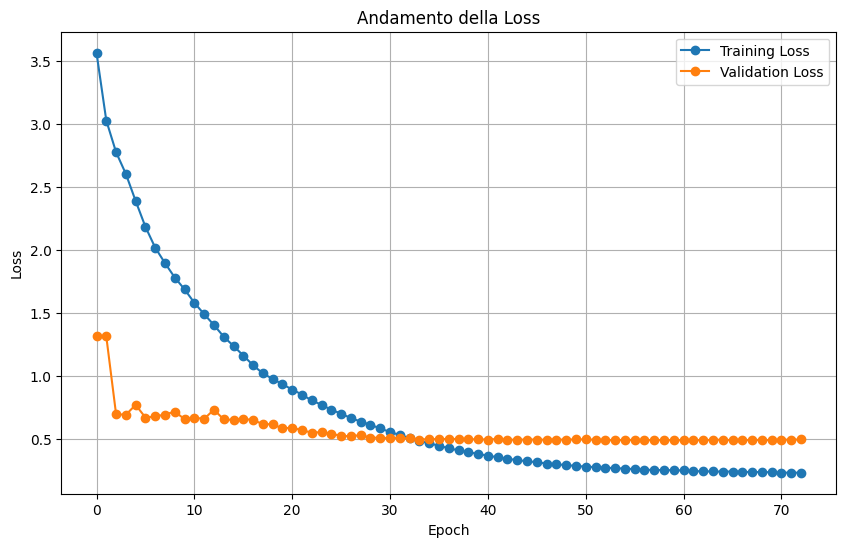

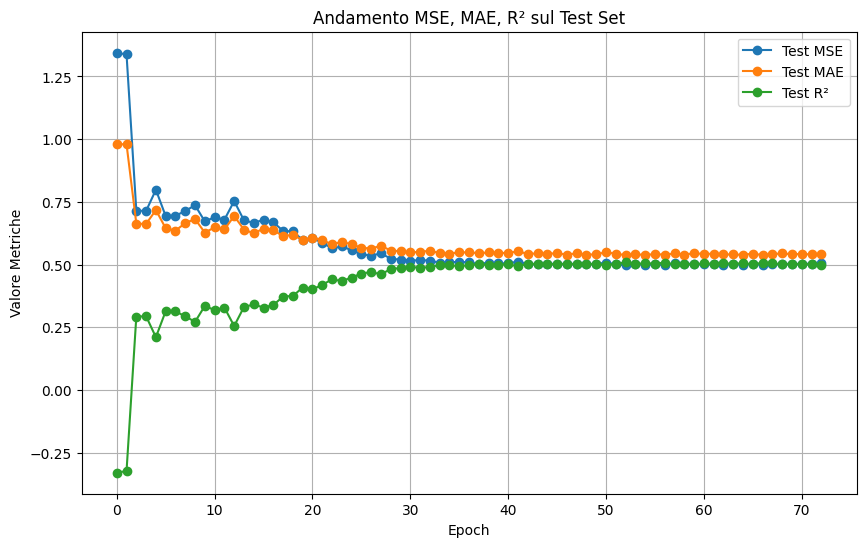

In [ ]:
# Plot dell'andamento della loss durante le epoche
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Andamento della Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inserisci uno spazio HTML
display(HTML("<br><br><br>"))

# Plot delle metriche di validazione (MSE, MAE, R2)
plt.figure(figsize=(10,6))
plt.plot(test_mses, label='Test MSE', marker='o')
plt.plot(test_maes, label='Test MAE', marker='o')
plt.plot(test_r2s, label='Test R²', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Valore Metriche')
plt.title('Andamento MSE, MAE, R² sul Test Set')
plt.legend()
plt.grid(True)
plt.show()